# Collaboration and Competition

Here is my solution to the third project of the udacity deep reinforcement learning nanodegree.

The goal of this project is training agents to play tennis. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent
from replay_buffer import ReplayBuffer

The following cells load the tennis environment and describe the environment

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Agent and Neural Network architecture
Here is the initialization of the two ddpg agent and all the hyper parameters used (minus the model's layer unit sizes which I have defined in model.py)

I kept the model, agent and hyperparameters very close to what I used in project 2. I had to tweak a few things. 

Most importantly the two agents share a replay buffer such that their experience is combined when training. 

I  increased the value of the batch size which seemed to help by making the agent accumulate more experiences before the actor and critic start to learn. (The agent don't start learning until after the replay buffer has more than batch_size examples)

The model for the actor has three fully connected layers with a rectified linear unit (ReLU) activation function on the first two layers and uses tanh after the third layer. First two layers are 400, 300 units in size. The first 2 layers use relu as activation functions and the final layer uses tanh. 

The critic network uses 3 fully connected layers. This is down from 4 for the previous project. This seemed to help improve the speed of learning the value function. Layer 1 has 256 units, layer 2 has 128 units. Layer 1 and 2 use relu activation functions. 

Noise was added using an Ornstein-Uhlenbeck process (as recommended in the paper) theta and sigma were set as the same values as the paper 0.15 and 0.2 respectively. I noticed that the agents struggled to learn after a certain amount of episodes and tried removing the noise. This improved learning significantly. 

Another thing I changed was that I set weight_decay to 0. With weight_decay the agents seemed to get stuck either at the edge of their play area. After I removed the weight_decay accidentally on one of the agent I noticed that it was starting to succeeded at tracking the ball while the other was not. I removed it from both and finally was able to solve the problem. I may have had the values for weight decay set incorrectly. 


Here is the initalization of the agent and all the hyper parameters used.

In [ ]:
BUFFER_SIZE=int(1e6)
BATCH_SIZE=512
GAMMA=0.99     
TAU=1e-2
LR_ACTOR=1e-3     
LR_CRITIC=1e-3      
WEIGHT_DECAY=0
RANDOM_SEED=0

agent1 = Agent(
    state_size=state_size,
    action_size=action_size,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,    
    gamma=GAMMA,           
    tau=TAU,
    lr_actor=LR_ACTOR,       
    lr_critic=LR_CRITIC,        
    weight_decay=WEIGHT_DECAY,
    random_seed=RANDOM_SEED
)

agent2 = Agent(
    state_size=state_size,
    action_size=action_size,
    memory=agent1.memory, # Sharing replay memory between ddpg agents. 
    batch_size=BATCH_SIZE,    
    gamma=GAMMA,           
    tau=TAU,
    lr_actor=LR_ACTOR,       
    lr_critic=LR_CRITIC,        
    weight_decay=WEIGHT_DECAY,
    random_seed=RANDOM_SEED
)

Episode 100	Average Score: 0.00 best_score 0.09000000171363354
Episode 200	Average Score: 0.00 best_score 0.09000000171363354
Episode 300	Average Score: 0.04 best_score 0.10000000149011612
Episode 400	Average Score: 0.13 best_score 0.90000001341104516
Episode 462	Average Score: 0.50 best_score 2.6000000387430191
Environment solved in 462 episodes!	Average Score: 0.50


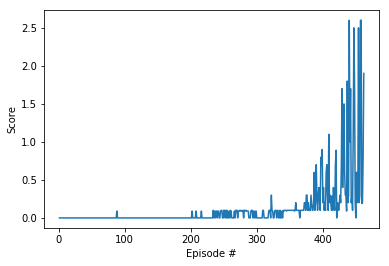

In [ ]:
STOP_NOISE_AFTER_EP=300
env_info = env.reset(train_mode=True)[brain_name]
def ddpg(n_episodes=1500, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    best_score = 0.0
    add_noise = True
    for i_episode in range(1, n_episodes+1):
        if i_episode > STOP_NOISE_AFTER_EP:
            add_noise = False
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent1.reset()
        agent2.reset()
        scores_ep = np.zeros(num_agents)
        while True:
            action1 = agent1.act(states[0], add_noise=add_noise).tolist()
            action2 = agent2.act(states[1], add_noise=add_noise).tolist()
            actions = [action1, action2]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent1.step(states[0], action1, rewards[0], next_states[0], dones[0])
            agent2.step(states[1], action2, rewards[1], next_states[1], dones[1])
            scores_ep += rewards
            states = next_states
            if np.any(dones):
                break
        max_score = np.max(scores_ep)
        scores_deque.append(max_score)
        scores.append(max_score)
        if max_score > best_score:
            best_score = max_score
        print('\rEpisode {}\tAverage Score: {:.2f} best_score {}'.format(i_episode, np.mean(scores_deque), best_score), end="")
        torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
        torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
        torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
        torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
            torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
            break
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Watch the agent

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        action1 = agent1.act(states[0], add_noise=False).tolist()
        action2 = agent2.act(states[1], add_noise=False).tolist()
        actions = [action1, action2]
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.10000000149011612
Score (max over agents) from episode 2: 0.7000000104308128
Score (max over agents) from episode 3: 0.4000000059604645
Score (max over agents) from episode 4: 0.6000000089406967


In [ ]:
env.close()

## Future Improvements
I've seen suggestions that others have had success with similar problems using using a Proximal Policy Optimization algorithm instead ddpg.

Another thing I'd like to train is share more information between agents. For example having the actor networks sync weights (I was thinking throught averaging them) after a certain amount of episodes. 